In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt
from qiskit import *
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# !pip3 install torchsummary

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution_pqc/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
# np.random.seed(0)           # Seed for NumPy random number generator
# tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [4]:
BATCH_SIZE = 4
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [5]:
token1 = '2b740fada862fb6d9683487f84455ff8fccb2caaa3988e4f406d321ef67ce0644eb679211a1b6a377ec5ee9b3839d34434255304ab535a9ed11ce60703f07446'
token2 = '08952555d263c29c9b015855d49bcbf0e7a3cb1354b5520743285bb48d19f0db420522be05c80dd1fb19179c42d798b238ae7b944568bb6e7e7284d9bfeb0209'

# from qiskit import IBMQ
# IBMQ.save_account(token2)
# provider = IBMQ.enable_account(token1)
dev = qml.device("default.qubit", wires=9)
# dev = qml.device('qiskit.ibmq', wires=9, backend='ibmq_qasm_simulator',provider=provider)
# IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# dev = qml.device('qiskit.ibmq', wires=9, backend='ibmq_qasm_simulator',
                #  ibmqx_token=token1, hub='ibm-q', group='open', project='main')
# print(dev.capabilities()['backend'])
# import pennylane as qml
# from pennylane_ionq import ops

# dev = qml.device("ionq.qpu", wires=9)

# Random circuit parameters

@qml.qnode(dev, interface='torch')
def pqc(data,params):
    # Encoding of 9 classical input values
    # len(params) = 2 * 9
    # print("data: ",data)
    # print("params: ",params)
    n_qubits = 9
    for j in range(n_qubits):
        qml.RY(np.pi * data[j], wires=j)
    
    # rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 9))
    # print("rand", rand_params)
    # PQC
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])    
    qml.CNOT(wires=[n_qubits-1,0])
    for i in range(n_qubits):
        qml.RY(params[i+n_qubits], wires=i)
    # Measurement producing 9 classical output values
    return qml.expval(qml.PauliZ(0))

In [6]:
print(pqc([1,0,2,1,2,3,1,2,0],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))

tensor(0.5919, dtype=torch.float64)


In [7]:
class QuanvNet(torch.nn.Module):
    def __init__(self,qc=True):
        super().__init__()
        self.n_qubits = 9
        self.filters = 1
        self.conv1 = torch.nn.Conv2d(in_channels=self.filters,out_channels=64,kernel_size=3)
        self.pre_pool = torch.nn.AvgPool2d(2)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(in_channels=50,out_channels=64,kernel_size=3)
        if qc == True:
          self.fc1 = torch.nn.Linear(1600,1024)
        else:
          self.fc1 = torch.nn.Linear(2304,1024)
        self.fc2 = torch.nn.Linear(1024,10)
        self.dropout = torch.nn.Dropout(0.4)
        self.q_params = torch.nn.Parameter(2*np.pi*torch.rand(12,12,self.filters,2*self.n_qubits))
        self.q_params.requires_grad = True

    def forward(self, inputs):
        inputs = self.pre_pool(inputs)/255
        qc = False
        if qc == True:
          out = torch.zeros((BATCH_SIZE,self.filters,12,12))
          for bat, image in enumerate(inputs):
              for j in range(1, 13, 1):
                  for k in range(1, 13, 1):
                      for i in range(self.filters):
                          q_results = pqc(
                          [
                              image[0, j - 1, k - 1].item(),
                              image[0, j - 1, k].item(),
                              image[0, j - 1, k + 1].item(),
                              image[0, j, k - 1].item(),
                              image[0, j, k].item(),
                              image[0, j, k + 1].item(),
                              image[0, j + 1, k - 1].item(),
                              image[0, j + 1, k].item(),
                              image[0, j + 1, k + 1].item()
                          ],
                              self.q_params[j-1,k-1,i]
                          )
                          out[bat,i,j - 1, k - 1] = q_results
        else:
          out = torch.zeros((BATCH_SIZE,self.filters,14,14))
          out = inputs
        x = self.pool(F.relu(self.conv1(out)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x



In [8]:
from torchsummary import summary
criterion = torch.nn.CrossEntropyLoss()
model = QuanvNet(qc=False)
model.cuda()
opt = optim.Adam(model.parameters(),lr=0.001)
summary(model,(1,28,28))

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
for p in model.parameters():
    print(p.shape)

torch.Size([12, 12, 1, 18])
torch.Size([64, 1, 3, 3])
torch.Size([64])
torch.Size([64, 50, 3, 3])
torch.Size([64])
torch.Size([1024, 2304])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


In [10]:
cd 

data/  drive/  sample_data/


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [111]:
for i,(x_train, y_train) in enumerate(train_loader):
    # print(x_train.size(),y_train.size())
    opt.zero_grad()
    outputs = model(x_train)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs,y_train)
    # print(loss.data)
    # print(loss.grad)
    # for p in model.parameters():
    #   print(p)
    #   print("hi",p.grad)
    loss.backward()
    
    opt.step()
    # for p in model.parameters():
    #   print(p)
    #   print("hi",p.grad)
    # print(loss.grad)
    if i%100 == 99:
      print(i+1,loss)
    # break
    # processed = ql.forward(inputs=x_train)
    # print(processed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


100 tensor(2.3032, grad_fn=<NllLossBackward>)
200 tensor(2.3181, grad_fn=<NllLossBackward>)
300 tensor(2.3172, grad_fn=<NllLossBackward>)
400 tensor(2.2841, grad_fn=<NllLossBackward>)
500 tensor(2.2948, grad_fn=<NllLossBackward>)
600 tensor(2.2587, grad_fn=<NllLossBackward>)
700 tensor(2.3385, grad_fn=<NllLossBackward>)
800 tensor(2.2984, grad_fn=<NllLossBackward>)
900 tensor(2.3108, grad_fn=<NllLossBackward>)
1000 tensor(2.2892, grad_fn=<NllLossBackward>)
1100 tensor(2.3029, grad_fn=<NllLossBackward>)
1200 tensor(2.2974, grad_fn=<NllLossBackward>)
1300 tensor(2.2989, grad_fn=<NllLossBackward>)
1400 tensor(2.2995, grad_fn=<NllLossBackward>)
1500 tensor(2.3001, grad_fn=<NllLossBackward>)
1600 tensor(2.2937, grad_fn=<NllLossBackward>)
1700 tensor(2.2943, grad_fn=<NllLossBackward>)
1800 tensor(2.3058, grad_fn=<NllLossBackward>)
1900 tensor(2.3039, grad_fn=<NllLossBackward>)


KeyboardInterrupt: ignored

In [ ]:
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1,50,3)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(50,64,3)
        self.fc1 = torch.nn.Linear(1024,1024)
        self.fc2 = torch.nn.Linear(1024,10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [ ]:
convnet = ConvNet()


In [ ]:
params = Variable(torch.rand(18),requires_grad=True)
opt = torch.optim.Adam(convnet.parameters(), lr = 0.001)

In [ ]:
for x_train, y_train in train_loader:
    processed = 

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=50,kernel_size=(5,5),activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.6855 - accuracy: 0.0800 - val_loss: 2.2814 - val_accuracy: 0.2333
Epoch 2/30
13/13 - 0s - loss: 2.2624 - accuracy: 0.1800 - val_loss: 2.2615 - val_accuracy: 0.2667
Epoch 3/30
13/13 - 0s - loss: 2.1351 - accuracy: 0.1800 - val_loss: 2.1811 - val_accuracy: 0.2667
Epoch 4/30
13/13 - 0s - loss: 1.9296 - accuracy: 0.3400 - val_loss: 2.0279 - val_accuracy: 0.4000
Epoch 5/30
13/13 - 0s - loss: 1.4940 - accuracy: 0.6200 - val_loss: 1.7861 - val_accuracy: 0.4000
Epoch 6/30
13/13 - 0s - loss: 1.0634 - accuracy: 0.7400 - val_loss: 1.2847 - val_accuracy: 0.6333
Epoch 7/30
13/13 - 0s - loss: 0.4327 - accuracy: 0.9000 - val_loss: 0.9241 - val_accuracy: 0.7333
Epoch 8/30
13/13 - 0s - loss: 0.1675 - accuracy: 1.0000 - val_loss: 1.0335 - val_accuracy: 0.6667
Epoch 9/30
13/13 - 0s - loss: 0.1081 - accuracy: 0.9800 - val_loss: 1.0861 - val_accuracy: 0.6667
Epoch 10/30
13/13 - 0s - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0.9634 - val_accuracy: 0.7667
Epoch 11/30
13/13 -

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3459 - accuracy: 0.0800 - val_loss: 2.2259 - val_accuracy: 0.4333
Epoch 2/30
13/13 - 0s - loss: 2.1432 - accuracy: 0.3200 - val_loss: 1.8568 - val_accuracy: 0.5333
Epoch 3/30
13/13 - 0s - loss: 1.5994 - accuracy: 0.5200 - val_loss: 1.3608 - val_accuracy: 0.5667
Epoch 4/30
13/13 - 0s - loss: 0.8348 - accuracy: 0.7200 - val_loss: 1.0210 - val_accuracy: 0.6667
Epoch 5/30
13/13 - 0s - loss: 0.5335 - accuracy: 0.7800 - val_loss: 0.8773 - val_accuracy: 0.7000
Epoch 6/30
13/13 - 0s - loss: 0.2980 - accuracy: 0.9200 - val_loss: 0.8824 - val_accuracy: 0.8000
Epoch 7/30
13/13 - 0s - loss: 0.1387 - accuracy: 0.9600 - val_loss: 0.7904 - val_accuracy: 0.8000
Epoch 8/30
13/13 - 0s - loss: 0.0568 - accuracy: 1.0000 - val_loss: 0.6582 - val_accuracy: 0.8333
Epoch 9/30
13/13 - 0s - loss: 0.0337 - accuracy: 1.0000 - val_loss: 0.9885 - val_accuracy: 0.7333
Epoch 10/30
13/13 - 0s - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.9936 - val_accuracy: 0.8000
Epoch 11/30
13/13 -

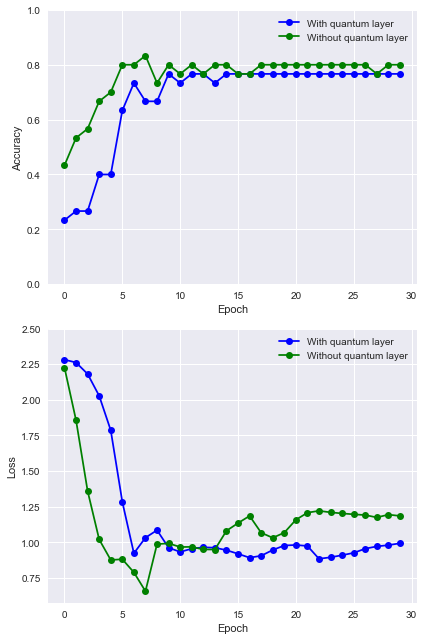

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()